# **Proyecto 10a**: Estudio del rendimiento de RNNs y su comportamiento a distintos largos de secuencia.
#Inteligencia Computacional EL4106-1 Primavera 2023

**Profesor**
- Pablo Estévez

**Profesor Auxiliar**
- Juan Urrutia

**Ayudante**
- Alejandro Luzanto

**Estudiantes:**
- Agustín González
- Diego Torreblanca

## Importar librerías y archivos

Importamos librerías a utilizar

In [ ]:
import torch
import torch.nn as nn
import torchaudio
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time
from tqdm.notebook import tqdm
from pprint import pprint
from typing import Tuple, Callable, Optional, List
from torchaudio.datasets.utils import _load_waveform

Versión de `Python 3`

In [ ]:
!python --version

Python 3.10.12


Importamos lista con archivos de audio que serán usados en validación, entrenamiento y testeo.

In [ ]:
files_dict = {
    "train_list.txt": "1rkwGTHlMWp1HAUSZK2zMhzzYGcb7Tb3y",
    "test_list.txt": "1dsMqujN1uFEHjZy77d2K64NwIiN4vibv",
    "val_list.txt": "1Q6nP5QZFvSO3sP6-1_Q7aIXgiod6LsJj"
}

for file_name, file_url in files_dict.items():

    url = f'https://drive.usercontent.google.com/download?id={file_url}&export=download'
    urllib.request.urlretrieve(url, "./" + file_name)

## Carga de los datasets

In [ ]:
# Se definen las labels que serán válidas
VALID_LABELS = ["yes", "no", "up", "down", "left", "right", "on",
"off", "stop", "go", "unknown word"]

# Cantidad de MFCC (coeficientes)
N_MFCC = 14

# Importar Dataset
# Clase que nos permite cargar el dataset y recorrer solo los archivos que nos interesa recorrer
# por cada caso (validación, entrenamiento, testeo)
class CustomSpeechCommands(torchaudio.datasets.SPEECHCOMMANDS):

    def __init__(self, subset_to_download: str = "all",
                 load_in_mem: bool = True, mem_transform: Optional[Callable] = None):
        super().__init__("", download=True, subset=None, url="speech_commands_v0.02")

        self._data = None
        self._transform = None
        self._in_mem = load_in_mem

        if subset_to_download == "validation":
            self._walker = self.load_list("val_list.txt")
        elif subset_to_download == "testing":
            self._walker = self.load_list("test_list.txt")
        elif subset_to_download == "training":
            self._walker = self.load_list("train_list.txt")
        else:
            raise RuntimeError("Invalid subset")

        # If to save in memory
        if self._in_mem:
            self._transform = mem_transform
            self._data = self.memory_load()
            print(f"Loaded {subset_to_download} data in memory.")


    def load_list(self, *filenames) -> List[str]:
        """Carga y devuelve las rutas a los archivos de audio a utilizar"""

        output = []
        for filename in filenames:
            filepath = os.path.join("", filename)
            with open(filepath) as fileobj:
                output += [os.path.normpath(
                    os.path.join("./SpeechCommands/speech_commands_v0.02/",
                                 line.strip())) for line in fileobj]
        return output

    def memory_load(self) -> List[Tuple]:
        """Carga en memoria los audios y etiquetas, aplica target_transform de haber"""

        number_of_audios = len(self._walker)
        data = [None] * number_of_audios
        longest_wv = 0
        for n in range(number_of_audios):
            metadata = self.get_metadata(n)
            waveform = _load_waveform(self._archive, metadata[0], metadata[1])

            longest_wv = waveform.shape[1] if waveform.shape[1] > longest_wv else longest_wv

            data[n] = (waveform,) + metadata[1:]

            if n % 300 == 0:
                print(f"\rLoading data in memory - {n / number_of_audios * 100:.2f}%", end="")

        if self._transform:
            print("\rApplying target transform to data in memory", end="")

            step_size = 150
            for batch_idx in range(0, len(data), step_size):
                end_idx = batch_idx + step_size

                data[batch_idx:end_idx] = self._transform(
                                                        data[batch_idx:end_idx],
                                                        torch.empty((1, longest_wv))
                                                        )

            print("\r", end="")

        return data


    def __getitem__(self, n: int) -> Tuple[torch.Tensor, int, str, str, int]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            Tuple of the following items;

            Tensor:
                Waveform
            int:
                Sample rate
            str:
                Label
            str:
                Speaker ID
            int:
                Utterance number
        """

        if self._in_mem:
            return self._data[n]
        else:
            metadata = self.get_metadata(n)
            waveform = _load_waveform(self._archive, metadata[0], metadata[1])
            return (waveform,) + metadata[1:]


def label_to_tensor(label: str) -> torch.Tensor:
    """Dado una etiqueta entrega un tensor con un número que representa el índice de la etiqueta"""

    if label.lower() in VALID_LABELS:
        index = VALID_LABELS.index(label)
    else:
        index = len(VALID_LABELS) - 1

    return torch.tensor(index)


def target_transform(batch, pad_to_length: torch.Tensor = torch.empty([1, 1])):
    """Procesa los audios y etiquetas para que tengan el formato adecuado"""
    WINDOW_SIZE = 40e-3 # Ventana de 40 ms de forma predeterminada
    SAMPLE_RATE = 16_000
    N_FFT = int(SAMPLE_RATE * WINDOW_SIZE)
    HOP_LENGTH = N_FFT // 2 # Overlap del 50%

    # Se recupera cada audio y etiqueta del batch para procesar
    audios, labels = [], []

    for audio, _, label, *_ in batch:
        audios.append(audio.t())
        labels.append(label_to_tensor(label))
    # Tensor con las etiquetas
    labels = torch.stack(labels)

    # Los audios tienen largos distintos, por lo que se rellenan con ceros para que queden todos
    # iguales.
    audios = torch.nn.utils.rnn.pad_sequence(audios + [pad_to_length.t()],
                                              batch_first=True)\
                                .squeeze()
    audios = audios[:-1]
    # Se crea el transformador a MCC
    mfcc = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC,
                                   melkwargs= {
                                       "hop_length": HOP_LENGTH,
                                       "n_fft": N_FFT
                                   })
    # Se calculan los MFCC de los audios
    mfcc_vals = mfcc(audios)
    # Se calcula los delta de los audios
    delta = torchaudio.functional.compute_deltas(mfcc_vals) # (batch, 14, 51) cambiar la cantidad de features
    # Se calcula los delta-delta de los audios
    delta2 = torchaudio.functional.compute_deltas(delta)
    # Se concatenan las 3 características, compartiendo la dimensión del tiempo
    audios = torch.cat((mfcc_vals, delta, delta2), dim=1).permute(0, 2, 1) # BATCH, LENGTH, INPUT

    audios_with_label = list(zip(audios, labels))

    return audios_with_label

In [ ]:
# Se crean los datasets
train_dataset = CustomSpeechCommands("training", mem_transform=target_transform)
val_dataset = CustomSpeechCommands("validation", mem_transform=target_transform)
test_dataset = CustomSpeechCommands("testing", mem_transform=target_transform)

100%|██████████| 2.26G/2.26G [00:34<00:00, 70.6MB/s]


Loaded training data in memory.
Loaded validation data in memory.
Loaded testing data in memory.


In [ ]:
# Dataloaders para los 3 tipos de audios
BATCH_SIZE = 128
SHUFFLE_DL = True

In [ ]:
# Se asume que se usará GPU
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True,
    num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True)

Escuchamos uno de los audios

In [ ]:
# Zero
SAMPLE_RATE = 16000
ipd.Audio(train_dataset[-1][0], rate=SAMPLE_RATE)

## Gráficos

Gráficos de las curvas de entrenamiento y validación

In [ ]:
def show_curves(all_curves, model_name):

    min = np.inf
    for curve in all_curves:
        new_min = len(curve["val_loss"])
        min = new_min if new_min < min else min

    for curve in all_curves:
        for i in curve.keys():
            curve[i] = curve[i][:min]

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training for ' + model_name)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training for ' + model_name)
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

Métricas y Matriz de Confusión

In [ ]:
def confusion_matrix(model, dataloader, model_name):
    model.cpu()
    model.eval()
    y_true = []
    y_pred = []

    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(model_name + " metrics\n")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1 * 100:.2f}%")

    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=VALID_LABELS,
                                            xticks_rotation=30, normalize="all", values_format='.4f')

    fig = disp.ax_.get_figure()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.title("Confusion Matrix for " + model_name)
    plt.show()

## Funciones/Clases de entrenamiento

In [ ]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    epoch_tolerance=3
):
    if use_gpu:
        model.cuda()

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    early_stopping = EarlyStopping(epoch_tolerance)

    post = {
        "val_loss": 0,
        "val_acc": 0,
        "train_loss": 0,
        "train_acc": 0
    }

    for epoch in range(epochs):

        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        description = f"Running Epoch {epoch+1}"

        my_pbar = tqdm(train_loader, leave=False)
        my_pbar.set_description(description)

        # Entrenamiento del modelo
        model.train()

        for x_batch, y_batch in my_pbar:
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            my_pbar.set_postfix(post)

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()

            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        post["val_loss"] = val_loss
        post["val_acc"] = val_acc
        post["train_acc"] = train_acc
        post["train_loss"] = train_loss

        # Early Stopping
        if early_stopping(val_loss):
            pprint(post)
            print("\nEarly stopping.")
            break


    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

## Modelos

### Modelo LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()
        self.lstm = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size * 2 if bidirectional else hidd_size, len(VALID_LABELS)),
            nn.Softmax(dim=1)
        )
        self.bidir = bidirectional

    def forward(self, x):
        _, (h, _) = self.lstm(x)

        hs = h[-1]
        if self.bidir:
            hs = torch.concatenate((h[-1], h[-2]), -1)

        return self.net(hs)

    def __str__(self):
        return type(self).__name__

### Modelo GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()
        self.gru = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size * 2 if bidirectional else hidd_size, len(VALID_LABELS)),
            nn.Softmax(dim=1)
        )
        self.bidir = bidirectional

    def forward(self, x):
        _, h = self.gru(x)

        hs = h[-1]
        if self.bidir:
            hs = torch.concatenate((h[-1], h[-2]), -1)

        return self.net(hs)

    def __str__(self):
        return type(self).__name__

### Modelo RNN Vanilla

In [ ]:
class RNNModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()
        self.rnn = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size * 2 if bidirectional else hidd_size, len(VALID_LABELS)),
            nn.Softmax(dim=1)
        )
        self.bidir = bidirectional

    def forward(self, x):
        _, h = self.rnn(x)

        hs = h[-1]
        if self.bidir:
            hs = torch.concatenate((h[-1], h[-2]), -1)

        return self.net(hs)

    def __str__(self):
        return type(self).__name__

### Modelo CNN + RNN Vanilla

In [ ]:
class CNN_RNN_Model(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()

        self.bidir = bidirectional

        # Hiperparámetros para bloque CNN
        kernel = 3
        stride = 1
        avg_size = 2

        # Se utiliza convolución 1D dado que tenemos 42 canales y el largo de la secuencia,
        # que es 51 para una ventana de 40 ms y un overlap de 50%, dados los audios de 1 segundo a 16 kHz
        # Capa CNN + Avg Pooling
        self.conv_blocks = nn.Sequential(
            # Bloque 1
            nn.Conv1d(
              in_channels = n_input_channels,
              out_channels=n_input_channels,
              kernel_size = kernel,
              stride = stride
              ),
            nn.AvgPool1d(kernel_size = avg_size),
            # Bloque 2
            nn.Conv1d(
              in_channels = n_input_channels,
              out_channels=n_input_channels,
              kernel_size = kernel,
              stride = stride
              ),
            nn.AvgPool1d(kernel_size = avg_size),
            # Bloque 3
            nn.Conv1d(in_channels = n_input_channels,
                                 out_channels=n_input_channels,
                                 kernel_size = kernel,
                                 stride = stride),
            nn.AvgPool1d(kernel_size = avg_size)
        )
        #Capa RNN
        self.rnn = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size * 2 if bidirectional else hidd_size, len(VALID_LABELS)),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x_permuted = x.permute(0, 2, 1) # Permutar para entregárselo al bloque CNN
        y = self.conv_blocks(x_permuted) # Aplicar el bloque CNN
        conv_result = y.permute(0, 2, 1) # Devolverlo al orden original
        _, h = self.rnn(conv_result) # Entregárselo a la capa RNN

        hs = h[-1]
        if self.bidir:
            hs = torch.concatenate((h[-1], h[-2]), -1)

        return self.net(hs)

    def __str__(self):
        return type(self).__name__

### Modelo GRU + Atencion


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, hidd_size, bidirectional=False):
        super().__init__()
        self.hidd_size = hidd_size * 2 if bidirectional else hidd_size

        # Capas lineales Q, K, y V
        self.linear_q = nn.Linear(self.hidd_size,  self.hidd_size)
        self.linear_k = nn.Linear(self.hidd_size,  self.hidd_size)
        self.linear_v = nn.Linear(self.hidd_size,  self.hidd_size)

    def forward(self, h_n):

        # Utilizar la salida de la RNN para obtener Q, K y V
        Q = self.linear_q(h_n)
        K = self.linear_k(h_n)
        V = self.linear_v(h_n)

        # Cálculos para obtener la salida de la capa de atencion

        # scores = Q.K^T/sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.hidd_size, dtype=torch.float32))
        # A = Softmax(scores)
        attention_weights = nn.functional.softmax(scores, dim=-1)
        # A.V
        output = torch.matmul(attention_weights, V)

        return output

class GRU_Att(nn.Module):
    def __init__(
        self,
        n_input_channels,
        output_size = len(VALID_LABELS),
        hidd_size=256,
        num_layers=1,
        bidirectional=False,
    ):
        super().__init__()


        self.gru = nn.GRU(n_input_channels, hidd_size, num_layers, batch_first=True, bidirectional=False)
        self.attention = AttentionLayer(hidd_size, bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size * 4 if bidirectional else hidd_size * 2, output_size), # Doble del tamaño para tener en cuenta la atención
            nn.Softmax(dim=1)
        )
        self.bidir = bidirectional

    def forward(self, x):
        _, h = self.gru(x)
        hs = h[-1]
        if self.bidir:
            hs = torch.concatenate((h[-1], h[-2]), -1)
        context = self.attention(hs)
        combined = torch.cat((hs, context), dim=1)
        output = self.net(combined)

        return output

### Modelo CNN + GRU + Atencion


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, hidd_size, bidirectional=False):
        super().__init__()
        self.hidd_size = hidd_size * 2 if bidirectional else hidd_size

        # Capas lineales Q, K, y V
        self.linear_q = nn.Linear(self.hidd_size,  self.hidd_size)
        self.linear_k = nn.Linear(self.hidd_size,  self.hidd_size)
        self.linear_v = nn.Linear(self.hidd_size,  self.hidd_size)

    def forward(self, h_n):

        # Utilizar la salida de la RNN para obtener Q, K y V
        Q = self.linear_q(h_n)
        K = self.linear_k(h_n)
        V = self.linear_v(h_n)

        # Cálculos para obtener la salida de la capa de atencion

        # scores = Q.K^T/sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.hidd_size, dtype=torch.float32))
        # A = Softmax(scores)
        attention_weights = nn.functional.softmax(scores, dim=-1)
        # A.V
        output = torch.matmul(attention_weights, V)

        return output

class GRU_CNN_Att(nn.Module):
    def __init__(
        self,
        n_input_channels,
        output_size = len(VALID_LABELS),
        hidd_size=256,
        num_layers=1,
        bidirectional=False,
    ):
        super().__init__()

        # Hiperparámetros para bloque CNN
        kernel = 3
        stride = 1
        avg_size = 2

        # Se utiliza convolución 1D dado que tenemos 42 canales y el largo de la secuencia,
        # que es 51 para una ventana de 40 ms y un overlap de 50%, dados los audios de 1 segundo a 16 kHz
        # Capa CNN + Avg Pooling
        self.conv_blocks = nn.Sequential(
            # Bloque 1
            nn.Conv1d(
              in_channels = n_input_channels,
              out_channels= n_input_channels,
              kernel_size = kernel,
              stride = stride
              ),
            nn.AvgPool1d(kernel_size = avg_size)
        )

        self.gru = nn.GRU(n_input_channels, hidd_size, num_layers, batch_first=True, bidirectional=False)
        self.attention = AttentionLayer(hidd_size, bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size * 4 if bidirectional else hidd_size * 2, output_size), # Doble del tamaño para tener en cuenta la atención
            nn.Softmax(dim=1)
        )
        self.bidir = bidirectional

    def forward(self, x):
        x_permuted = x.permute(0, 2, 1) # Permutar para entregárselo al bloque CNN
        y = self.conv_blocks(x_permuted) # Aplicar el bloque CNN
        conv_result = y.permute(0, 2, 1) # Devolverlo al orden original
        _, h = self.gru(conv_result)
        hs = h[-1]
        if self.bidir:
            hs = torch.concatenate((h[-1], h[-2]), -1)
        context = self.attention(hs)
        combined = torch.cat((hs, context), dim=1)
        output = self.net(combined)

        return output

### Modelo LSTM + LN

In [ ]:
class LSTM_LN_Model(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        output_size=len(VALID_LABELS),
        bidirectional=False
    ):
        super().__init__()
        self.lstm = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.LayerNorm(hidd_size),
            nn.Linear(hidd_size * 2 if bidirectional else hidd_size, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        _, (h, _) = self.lstm(x)

        return self.net(h[-1])

    def __str__(self):
        return type(self).__name__

## Entrenamientos


### Entrenamiento del Modelo LSTM

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

lstm_all_curves = []
lstm_times = []

for train_run in range(n_trains):
    lstm_model = LSTMModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        lstm_model,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    lstm_all_curves.append(curves)
    lstm_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(lstm_times):.2f} +- {np.std(lstm_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Graficamos los resultados del entrenamiento

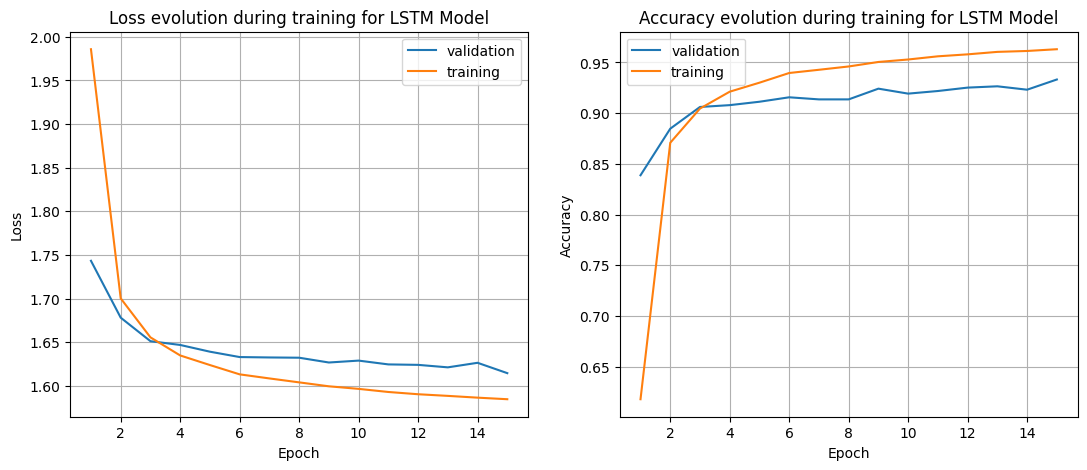

In [ ]:
show_curves(lstm_all_curves, "LSTM Model")

Graficamos la matriz de confusión y obtenemos las métricas

LSTM Model metrics

Accuracy: 91.46%
Precision: 91.56%
Recall: 91.52%
F1-score: 91.51%


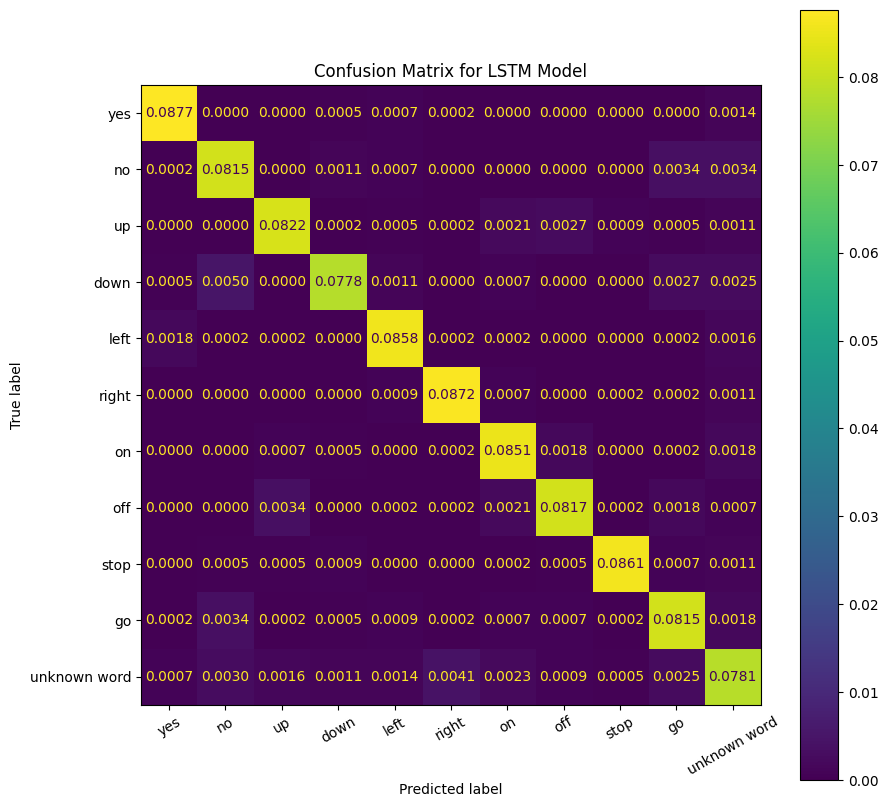

In [ ]:
confusion_matrix(lstm_model, test_loader, "LSTM Model")

### Entrenamiento del Modelo GRU

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 5
epochs = 30

hidden_size = 512
num_layers = 3

gru_all_curves = []
gru_times = []

for train_run in range(n_trains):
    model_gru = GRUModel(N_MFCC * 3, hidden_size, num_layers, bidirectional=False) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_gru,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    gru_all_curves.append(curves)
    gru_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(gru_times):.2f} +- {np.std(gru_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9139062644439652,
 'train_loss': 1.6292090091603058,
 'val_acc': 0.8949677419354839,
 'val_loss': 1.6469098693478492}

Early stopping.

Tiempo total de entrenamiento: 112.0217 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9213323883770376,
 'train_loss': 1.6212199282595487,
 'val_acc': 0.9073548387096774,
 'val_loss': 1.6350822570247034}

Early stopping.

Tiempo total de entrenamiento: 153.5947 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9287893261023634,
 'train_loss': 1.6142906615815868,
 'val_acc': 0.9148387096774193,
 'val_loss': 1.6291197870623682}

Early stopping.

Tiempo total de entrenamiento: 192.8917 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9420084429790775,
 'train_loss': 1.6011276810105965,
 'val_acc': 0.927483870967742,
 'val_loss': 1.6153700323412494}

Early stopping.

Tiempo total de entrenamiento: 278.5520 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9159399747326904,
 'train_loss': 1.6270120729155721,
 'val_acc': 0.903483870967742,
 'val_loss': 1.639945731839826}

Early stopping.

Tiempo total de entrenamiento: 140.2075 [s]
Tiempo de entrenamiento promedio de 5 corridas: 175.45 +- 57.75 [s]


Graficamos los resultados del entrenamiento

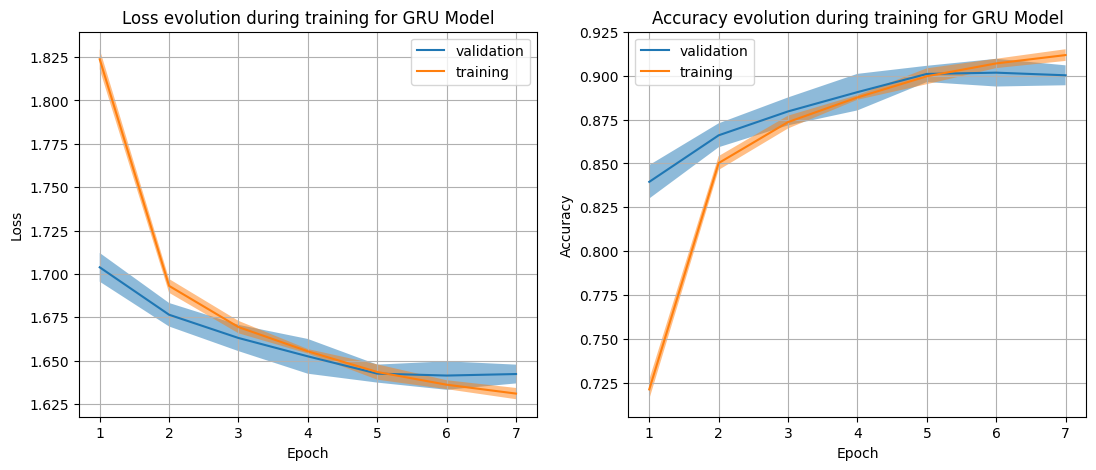

In [ ]:
show_curves(gru_all_curves, "GRU Model")

Graficamos la matriz de confusión y obtenemos las métricas

GRU Model metrics

Accuracy: 90.21%
Precision: 90.80%
Recall: 90.29%
F1-score: 90.31%


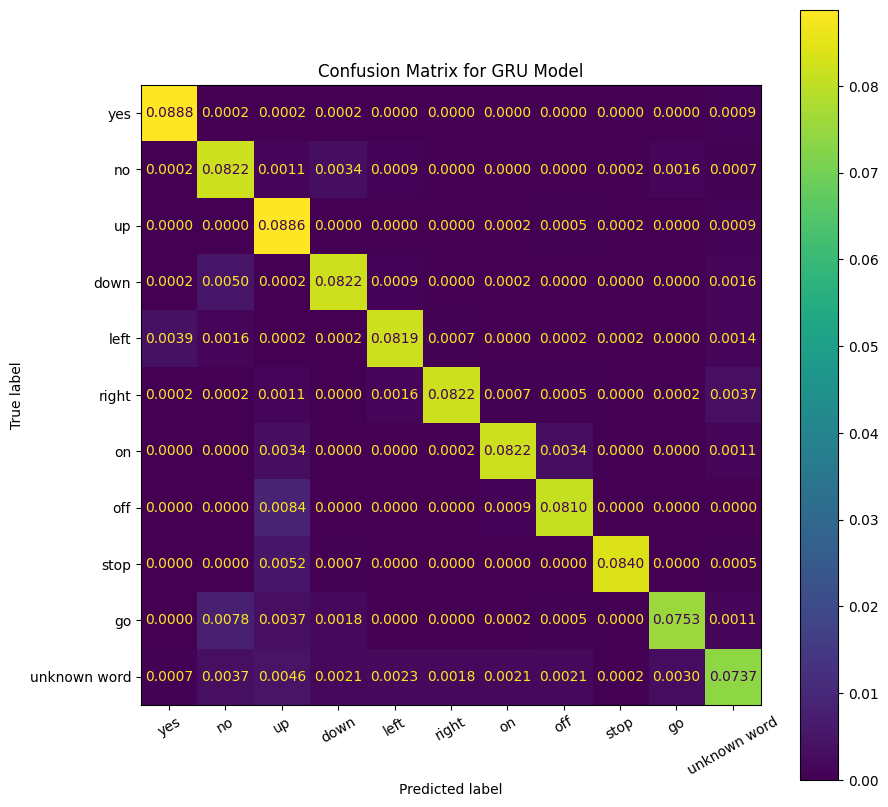

In [ ]:
confusion_matrix(model_gru, test_loader, "GRU Model")

### Entrenamiento del Modelo Vanilla RNN (Ventana de 40 ms)

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves = []
rnn_times = []

for train_run in range(n_trains):
    model_rnn = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves.append(curves)
    rnn_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times):.2f} +- {np.std(rnn_times):.2f} [s]")

Graficamos los resultados del entrenamiento

In [ ]:
show_curves(rnn_all_curves, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

In [ ]:
confusion_matrix(model_rnn, test_loader, "RNN Model")

### Entrenamiento del Modelo Vanilla RNN (Ventana de 80 ms)

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves_80 = []
rnn_times_80 = []

for train_run in range(n_trains):
    model_rnn_80 = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn_80,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves_80.append(curves)
    rnn_times_80.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times_80):.2f} +- {np.std(rnn_times_80):.2f} [s]")

Graficamos los resultados del entrenamiento

In [ ]:
show_curves(rnn_all_curves_80, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

In [ ]:
confusion_matrix(model_rnn_80, test_loader, "RNN Model")

In [ ]:
confusion_matrix(model_rnn_80, val_loader, "RNN Model")

### Entrenamiento del Modelo Vanilla RNN (Ventana de 120 ms)

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves_120 = []
rnn_times_120 = []

for train_run in range(n_trains):
    model_rnn_120 = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn_120,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves_120.append(curves)
    rnn_times_120.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times_120):.2f} +- {np.std(rnn_times_120):.2f} [s]")

Graficamos los resultados del entrenamiento

In [ ]:
show_curves(rnn_all_curves_120, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

In [ ]:
confusion_matrix(model_rnn_120, test_loader, "RNN Model")

In [ ]:
confusion_matrix(model_rnn_120, val_loader, "RNN Model")

### Entrenamiento del Modelo CNN + RNN

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 3
epochs = 30

hidden_size = 512
num_layers = 2

rnn_cnn_all_curves = []
rnn_cnn_times = []

for train_run in range(n_trains):
    model_cnn_rnn = CNN_RNN_Model(n_input_channels = N_MFCC * 3, hidd_size = hidden_size, num_layers = num_layers, bidirectional=True) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_cnn_rnn,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_cnn_all_curves.append(curves)
    rnn_cnn_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_cnn_times):.2f} +- {np.std(rnn_cnn_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.8252857979231504,
 'train_loss': 1.7216772971541012,
 'val_acc': 0.7956129032258065,
 'val_loss': 1.7486019182512837}

Early stopping.

Tiempo total de entrenamiento: 47.8938 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.8205404739161248,
 'train_loss': 1.7262941669162255,
 'val_acc': 0.7739354838709678,
 'val_loss': 1.7687535867998676}

Early stopping.

Tiempo total de entrenamiento: 33.4380 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.837272363109728,
 'train_loss': 1.7093510811558028,
 'val_acc': 0.8105806451612904,
 'val_loss': 1.7328121923938875}

Early stopping.

Tiempo total de entrenamiento: 73.7011 [s]
Tiempo de entrenamiento promedio de 3 corridas: 51.68 +- 16.65 [s]


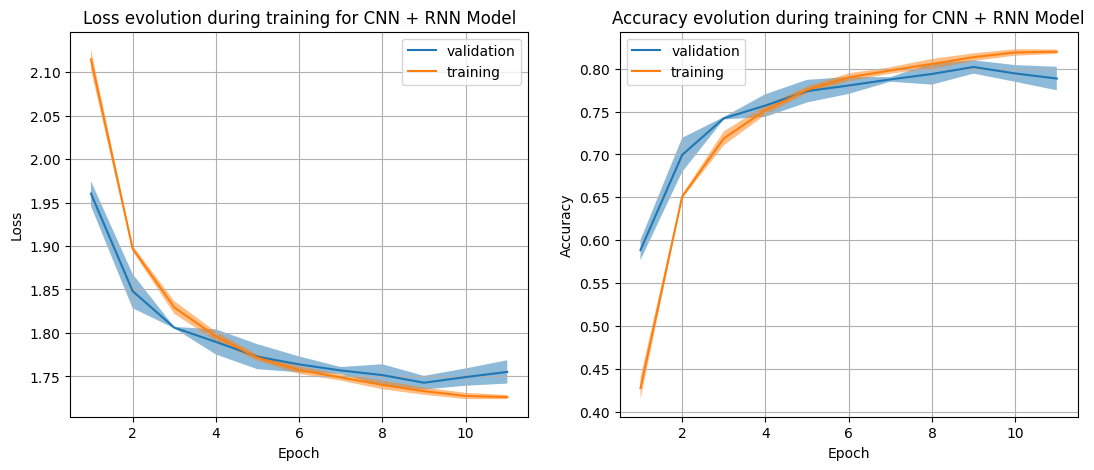

In [ ]:
show_curves(rnn_cnn_all_curves, "CNN + RNN Model")

CNN + RNN Model metrics

Accuracy: 78.29%
Precision: 78.65%
Recall: 78.42%
F1-score: 78.19%


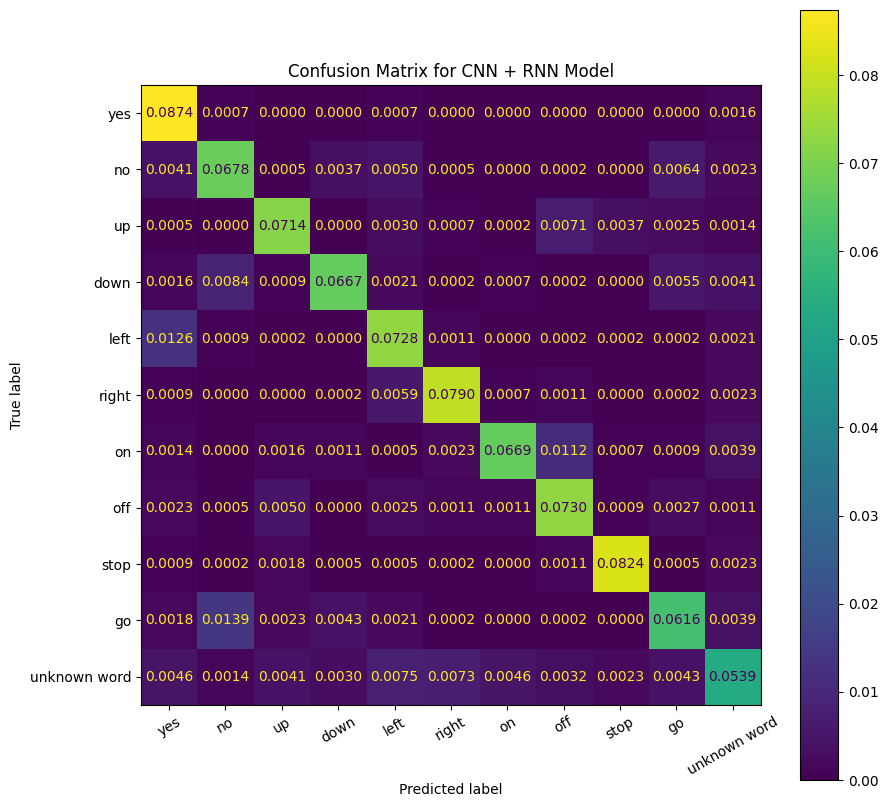

In [ ]:
confusion_matrix(model_cnn_rnn, test_loader, "CNN + RNN Model")

CNN + RNN Model metrics

Accuracy: 81.06%
Precision: 81.63%
Recall: 81.21%
F1-score: 80.93%


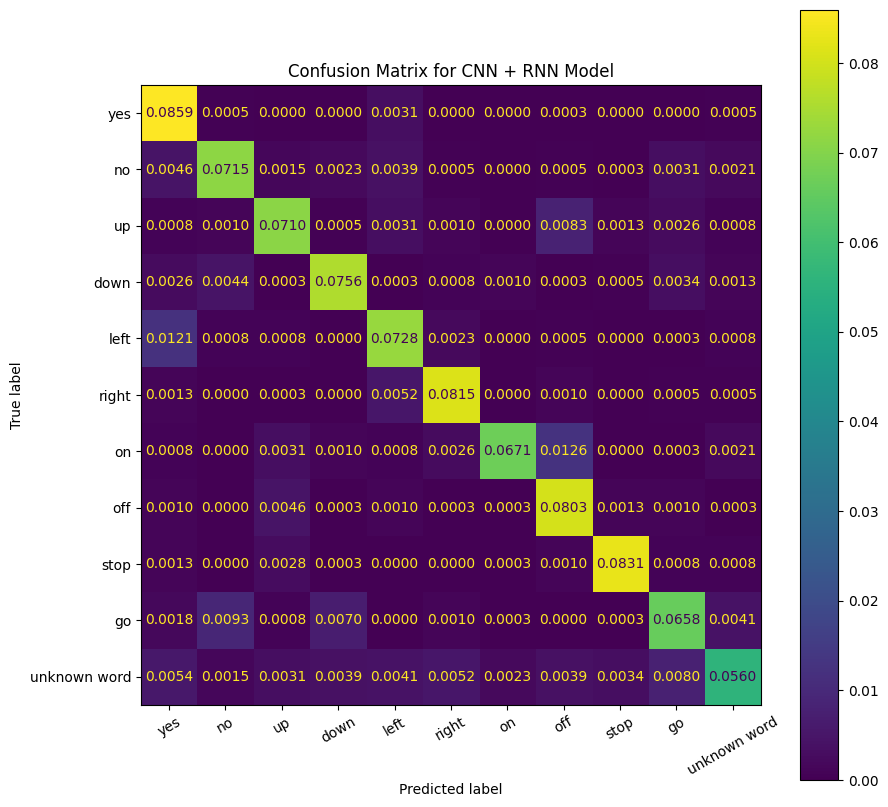

In [ ]:
confusion_matrix(model_cnn_rnn, val_loader, "CNN + RNN Model")

### Entrenamiento GRU + Atencion

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 5
epochs = 30

hidden_size = 256
num_layers = 3

gru_att_all_curves = []
gru_att_times = []

for train_run in range(n_trains):
    gru_att_model = GRU_Att(n_input_channels = N_MFCC * 3,
                            output_size = len(VALID_LABELS),
                            hidd_size = hidden_size,
                            num_layers = num_layers,
                            bidirectional=True
                            )

    curves, total_time = train_model(
        gru_att_model,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    gru_att_all_curves.append(curves)
    gru_att_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(gru_att_times):.2f} +- {np.std(gru_att_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9362770776199427,
 'train_loss': 1.6065596916993454,
 'val_acc': 0.911741935483871,
 'val_loss': 1.6314650939203077}

Early stopping.

Tiempo total de entrenamiento: 133.1307 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9187748436200043,
 'train_loss': 1.6240268601433205,
 'val_acc': 0.9019354838709678,
 'val_loss': 1.6407030962051883}

Early stopping.

Tiempo total de entrenamiento: 70.3950 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9119958093242535,
 'train_loss': 1.6308315636744115,
 'val_acc': 0.9006451612903226,
 'val_loss': 1.6408107029084236}

Early stopping.

Tiempo total de entrenamiento: 71.2613 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9226881952361877,
 'train_loss': 1.6197609337247567,
 'val_acc': 0.9112258064516129,
 'val_loss': 1.631255084099308}

Early stopping.

Tiempo total de entrenamiento: 88.2378 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.8919360305672819,
 'train_loss': 1.651103820983858,
 'val_acc': 0.8838709677419355,
 'val_loss': 1.6578255961018225}

Early stopping.

Tiempo total de entrenamiento: 38.7801 [s]
Tiempo de entrenamiento promedio de 5 corridas: 80.36 +- 30.85 [s]


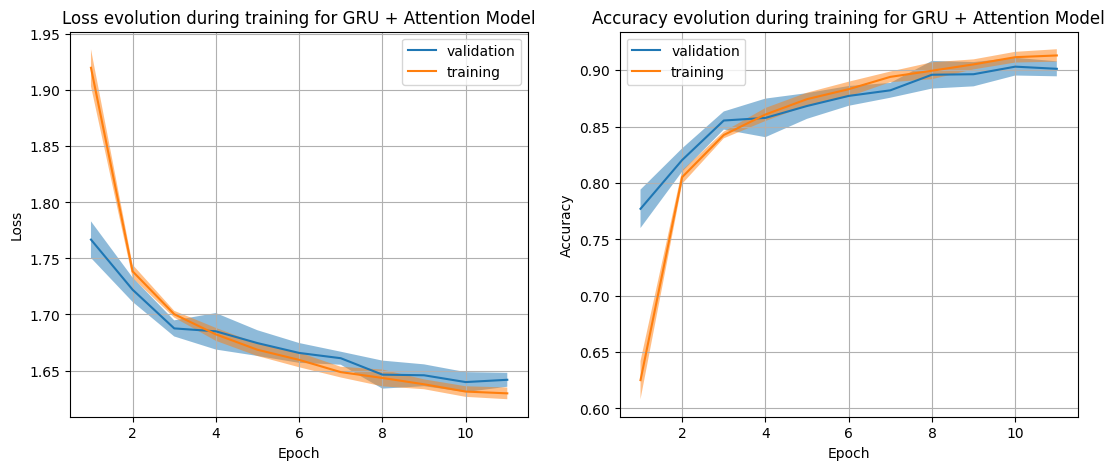

In [ ]:
show_curves(gru_att_all_curves, "GRU + Attention Model")

### Entrenamiento CNN + GRU + Atencion

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 5
epochs = 30

hidden_size = 256
num_layers = 3

gru_cnn_att_all_curves = []
gru_cnn_att_times = []

for train_run in range(n_trains):
    gru_cnn_att_model = GRU_CNN_Att(n_input_channels = N_MFCC * 3,
                            output_size = len(VALID_LABELS),
                            hidd_size = hidden_size,
                            num_layers = num_layers,
                            bidirectional=False
                            )

    curves, total_time = train_model(
        gru_cnn_att_model,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    gru_cnn_att_all_curves.append(curves)
    gru_cnn_att_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(gru_cnn_att_times):.2f} +- {np.std(gru_cnn_att_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9214556435460513,
 'train_loss': 1.6216396831920274,
 'val_acc': 0.9016774193548387,
 'val_loss': 1.6411288529365293}

Early stopping.

Tiempo total de entrenamiento: 47.5041 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9191754229192987,
 'train_loss': 1.6239554573970705,
 'val_acc': 0.9029677419354839,
 'val_loss': 1.6393351500726516}

Early stopping.

Tiempo total de entrenamiento: 45.9433 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.929436415739685,
 'train_loss': 1.6134815712142305,
 'val_acc': 0.9091612903225806,
 'val_loss': 1.633221835782451}

Early stopping.

Tiempo total de entrenamiento: 57.4020 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9025976026869627,
 'train_loss': 1.6401416151614614,
 'val_acc': 0.9050322580645161,
 'val_loss': 1.6369013854303667}

Early stopping.

Tiempo total de entrenamiento: 37.2636 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9120882507010137,
 'train_loss': 1.63089793832909,
 'val_acc': 0.8929032258064517,
 'val_loss': 1.6498934500601983}

Early stopping.

Tiempo total de entrenamiento: 40.4459 [s]
Tiempo de entrenamiento promedio de 5 corridas: 45.71 +- 6.91 [s]


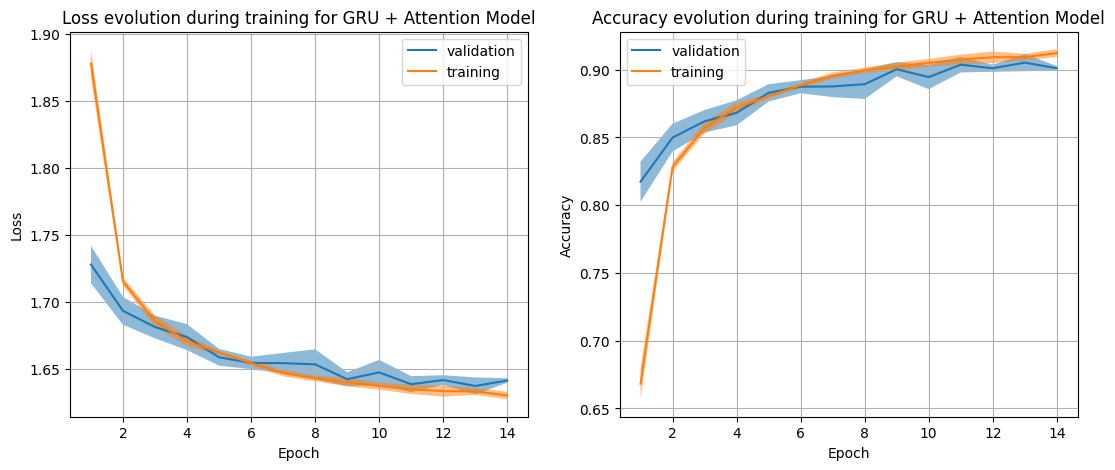

In [ ]:
show_curves(gru_cnn_att_all_curves, "GRU + Attention Model")

### Entrenamiento LSTM + LN

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 3
epochs = 30

hidden_size = 512
num_layers = 4

lstm_ln_all_curves = []
lstm_ln_times = []

for train_run in range(n_trains):
    lstm_ln = LSTM_LN_Model(n_input_channels = N_MFCC * 3,
                                       hidd_size = hidden_size,
                                       num_layers = num_layers,
                                       output_size = len(VALID_LABELS)) # MFCC, Delta, DeltaDelta
    curves, total_time = train_model(
        lstm_ln,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    lstm_ln_all_curves.append(curves)
    lstm_ln_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(lstm_ln_times):.2f} +- {np.std(lstm_ln_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.7985086124549349,
 'train_loss': 1.7441746972652112,
 'val_acc': 0.76,
 'val_loss': 1.7828550475951164}

Early stopping.

Tiempo total de entrenamiento: 392.9596 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.8451606939266015,
 'train_loss': 1.6975711124121777,
 'val_acc': 0.832516129032258,
 'val_loss': 1.7115806999206542}

Early stopping.

Tiempo total de entrenamiento: 421.5123 [s]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.8048254398668844,
 'train_loss': 1.7376649776188444,
 'val_acc': 0.7569032258064516,
 'val_loss': 1.7859654306288688}

Early stopping.

Tiempo total de entrenamiento: 450.5285 [s]


TypeError: ignored

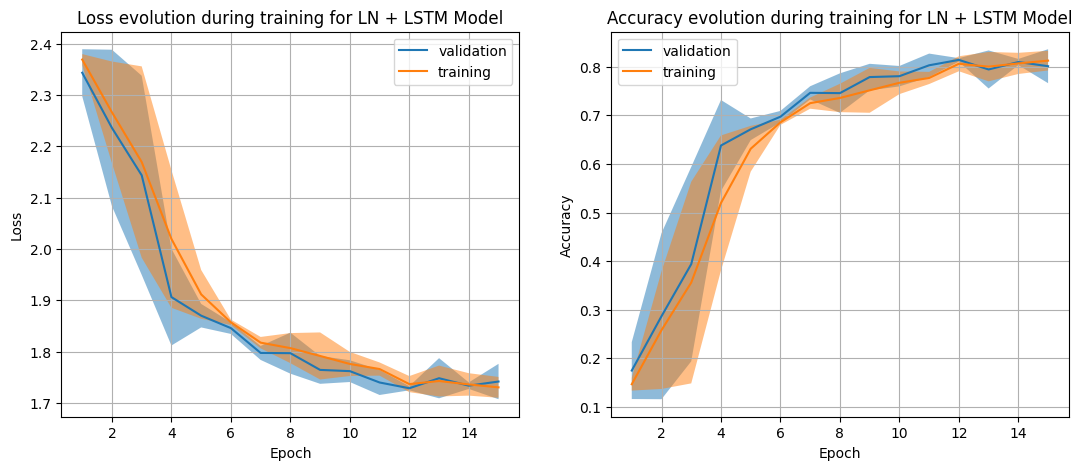

In [ ]:
show_curves(lstm_ln_all_curves, "LN + LSTM Model")

LSTM + LN Model metrics

Accuracy: 71.95%
Precision: 76.74%
Recall: 72.04%
F1-score: 71.80%


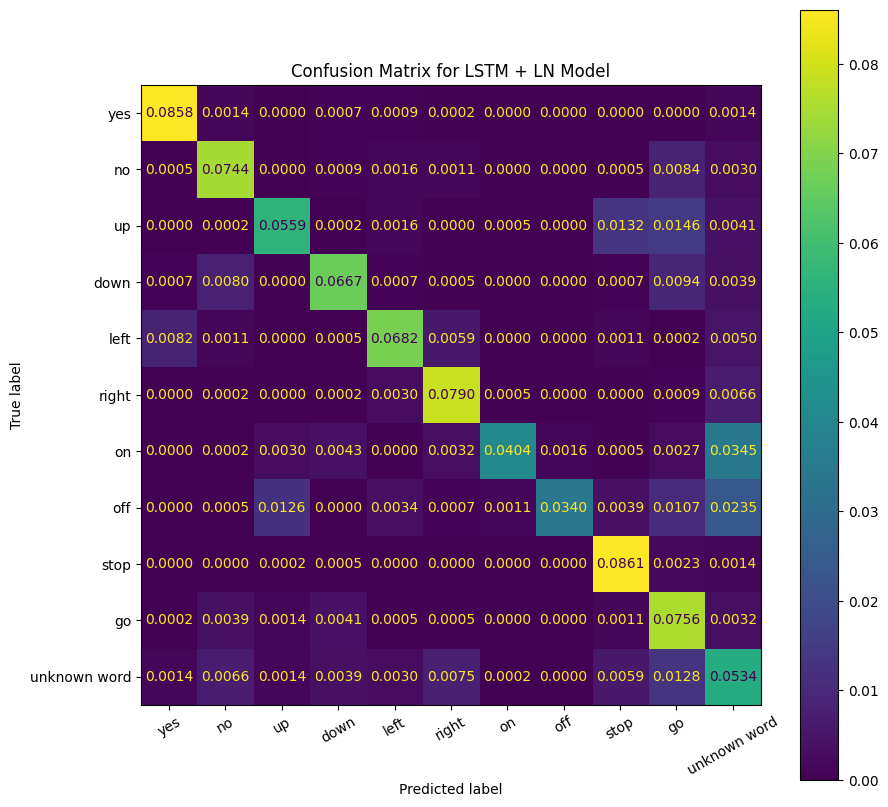

In [ ]:
confusion_matrix(lstm_ln, test_loader, "LSTM + LN Model")

LSTM + Att Model metrics

Accuracy: 75.69%
Precision: 80.07%
Recall: 75.73%
F1-score: 75.61%


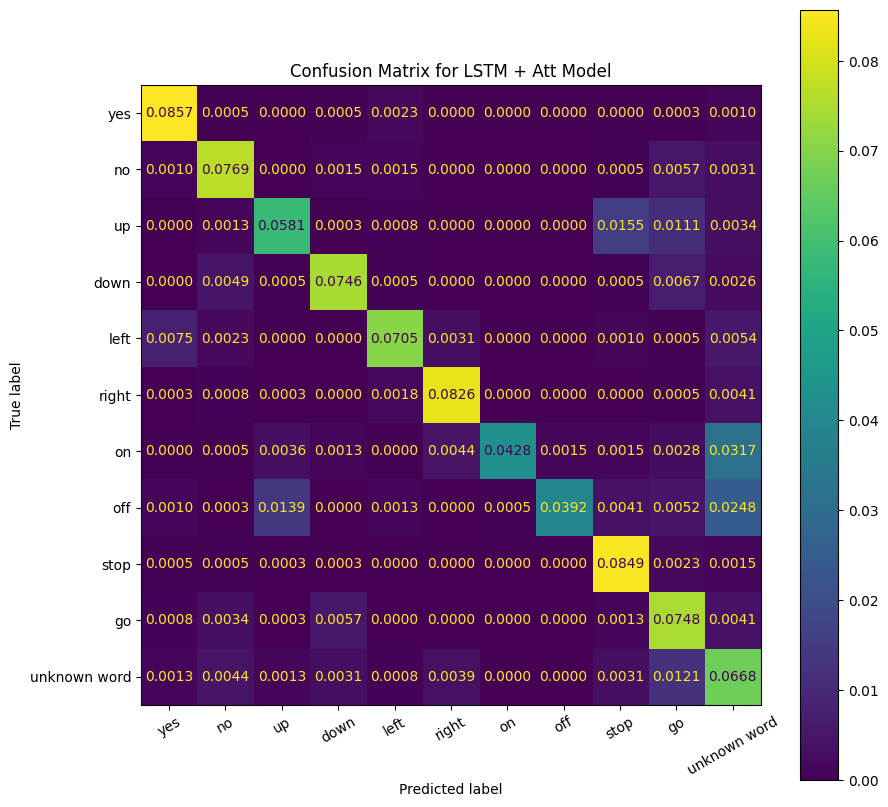

In [ ]:
confusion_matrix(lstm_ln, val_loader, "LSTM + Att Model")

## Wav2Vec2 (Transcripción)

### Funciones

Decodificador de la salida del modelo

In [ ]:
# https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        # Para nuestra implementación
        string = "".join([self.labels[i] for i in indices])
        string = string.lower().replace("|", "")
        return label_to_tensor(string)

Transformación a aplicar a los datos del dataset

In [ ]:
def data_transform_wav2vec(batch, pad_to_length: torch.Tensor = torch.empty([1, 1])):
    """Procesa los audios y etiquetas para que tengan el formato adecuado"""
    WINDOW_SIZE = 40e-3 # Ventana de 40 ms de forma predeterminada
    SAMPLE_RATE = 16_000

    # Se recupera cada audio y etiqueta del batch para procesar
    audios, labels = [], []

    for audio, _, label, *_ in batch:
        audios.append(audio.t())
        labels.append(label_to_tensor(label))
    # Tensor con las etiquetas
    labels = torch.stack(labels)

    # Los audios tienen largos distintos, por lo que se rellenan con ceros para que queden todos
    # iguales.
    audios = torch.nn.utils.rnn.pad_sequence(audios + [pad_to_length.t()],
                                              batch_first=True)\
                                .squeeze()
    audios = audios[:-1]

    audios_with_label = list(zip(audios, labels))

    return audios_with_label


Función que dado un subconjunto de los datos, predice las etiquetas y compara con las reales

In [ ]:
def evaluate_wav2vec(datasubset: str):
    bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
    Wav2VecModel = bundle.get_model().cuda()
    audios_dataset = CustomSpeechCommands(datasubset, mem_transform=data_transform_wav2vec)

    audio_loader = torch.utils.data.DataLoader(
                                            audios_dataset,
                                            batch_size=1,
                                            shuffle=SHUFFLE_DL,
                                            pin_memory=True)

    decoder = GreedyCTCDecoder(labels=bundle.get_labels())
    predicted = []
    correct = []

    print("Predicting audio labels... ", end="")
    for audio, label_idx in audio_loader:
        with torch.inference_mode():
            audio = audio.cuda()
            features, _ = Wav2VecModel.extract_features(audio)
            # print(features)
            fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
            for i, feats in enumerate(features):
                ax[i].imshow(feats[0].cpu(), interpolation="nearest")
                ax[i].set_title(f"Feature from transformer layer {i+1}")
                ax[i].set_xlabel("Feature dimension")
                ax[i].set_ylabel("Frame (time-axis)")
            fig.tight_layout()
            # print([f.shape for f in features])

            raise TimeoutError
            emission, _ = Wav2VecModel.forward(audio)

        pred = decoder(emission[0])
        predicted.append(pred)
        correct.append(label_idx)
    print("Done.")

    predicted = torch.stack(predicted)
    correct = torch.stack(correct)

    return predicted, correct

In [ ]:
# def get_wav2vec_features(datasubset: str):
#     bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
#     Wav2VecModel = bundle.get_model().cuda()
#     audios_dataset = CustomSpeechCommands(datasubset, mem_transform=data_transform_wav2vec)

#     audio_loader = torch.utils.data.DataLoader(
#                                             audios_dataset,
#                                             batch_size=1,
#                                             shuffle=SHUFFLE_DL,
#                                             pin_memory=True)
#     with torch.inference_mode():
#       features, _ = Wav2VecModel.extract_features(waveform)

### Evaluación del rendimiento de wav2vec2 con greedy decoder

In [ ]:
pred, true = evaluate_wav2vec("training")
acc = sum(pred == true.squeeze()) / len(pred)
print(f"Accuracy of Wav2Vec2 using greedy decoder on training data: {acc.item():.4f}")

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:04<00:00, 84.8MB/s]


Loading data in memory - 12.94%

KeyboardInterrupt: ignored

Loaded testing data in memory.
Predicting audio labels... 

TimeoutError: ignored

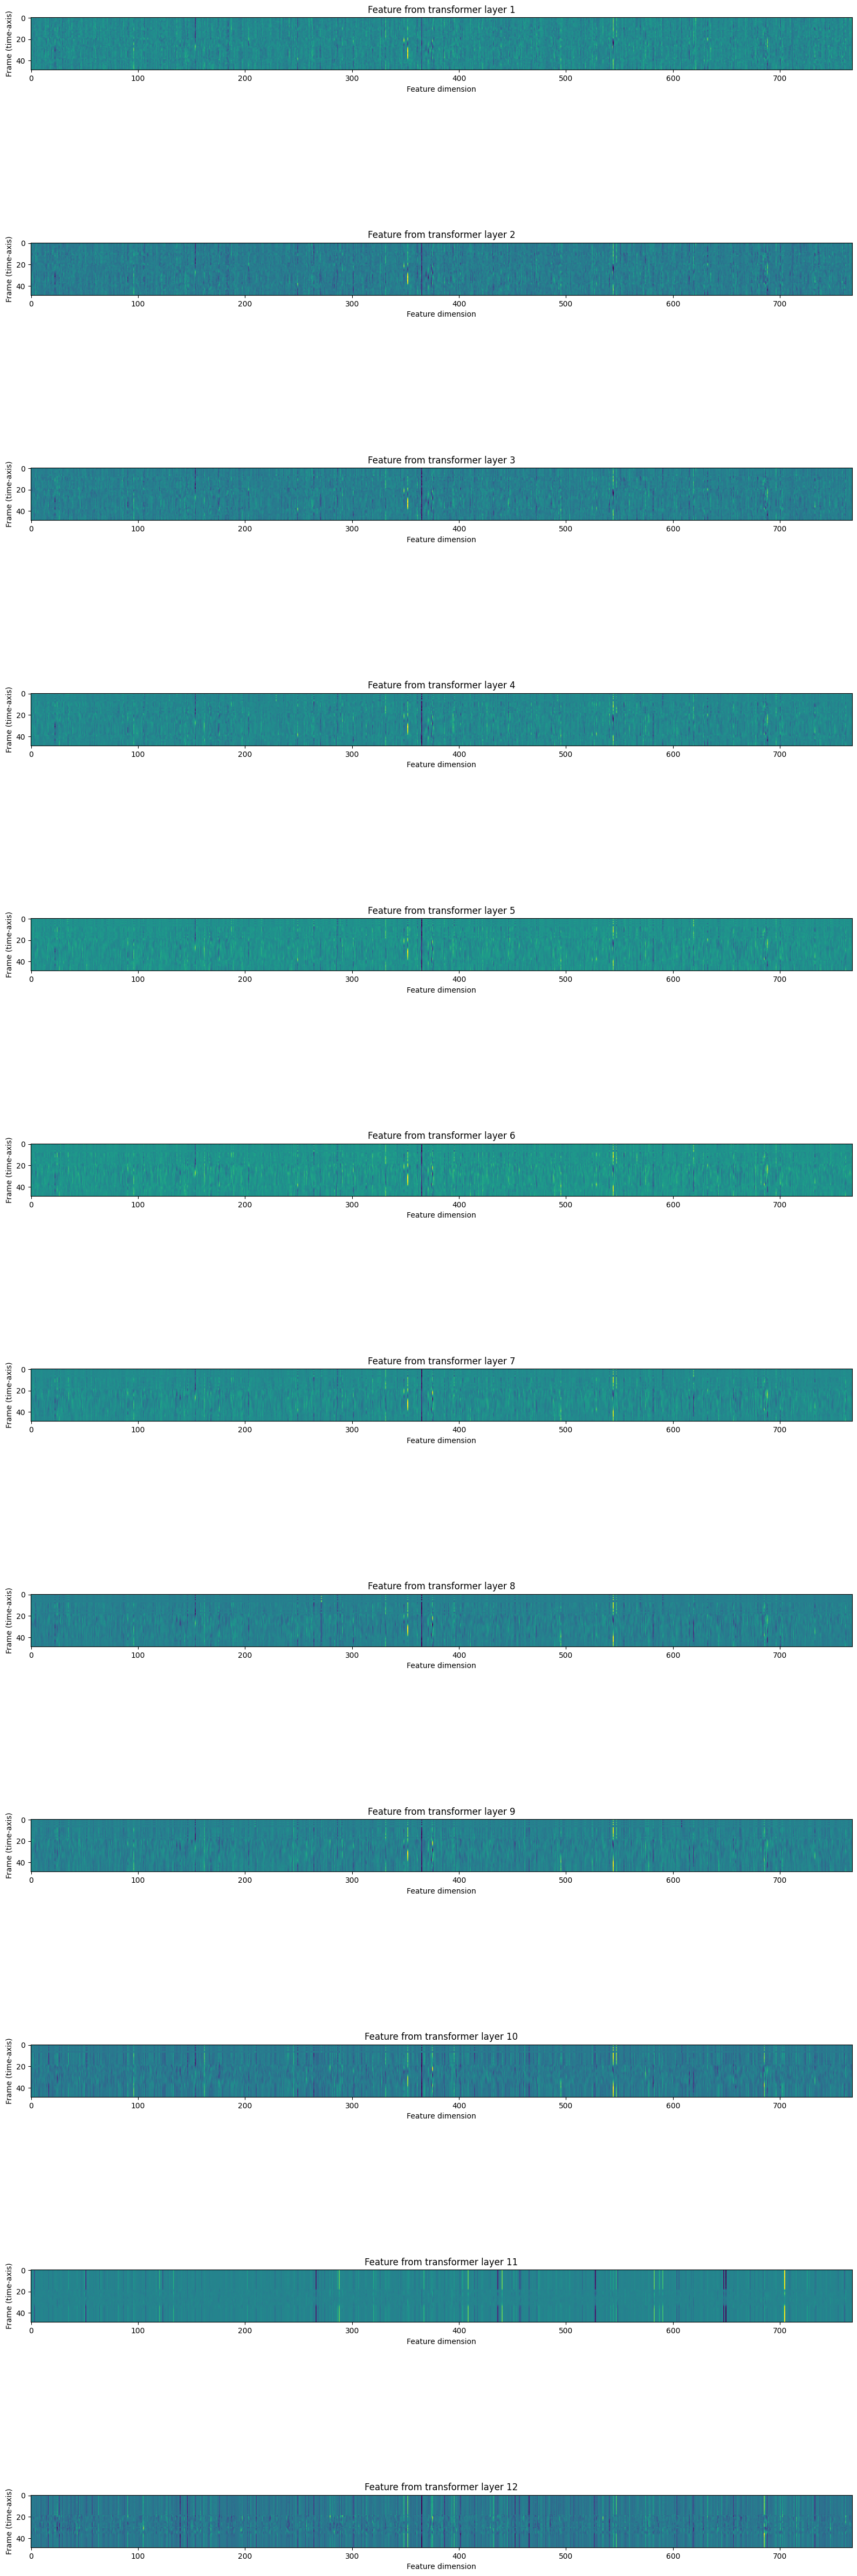

In [ ]:
pred, true = evaluate_wav2vec("testing")
acc = sum(pred == true.squeeze()) / len(pred)
print(f"Accuracy of Wav2Vec2 using greedy decoder on testing data: {acc.item():.4f}")

In [ ]:
pred, true = evaluate_wav2vec("validation")
acc = sum(pred == true.squeeze()) / len(pred)
print(f"Accuracy of Wav2Vec2 using greedy decoder on validation data: {acc.item():.4f}")

Loaded validation data in memory.
Predicting audio labels... Done.
Accuracy of Wav2Vec2 using greedy decoder on validation data: 0.7215


# WandB

In [ ]:
!pip install wandb -qU
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
# Aquí hay que poner la llave de WandB
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Comparación Inicial (ola 1):** Variación de Hiperparámetros base entre los modelos

#### Función de entrenamiento

In [ ]:
def train_model_wandb(
    config,
    model,
    use_gpu=True,
    epoch_tolerance=3,
    test_dloader=test_loader
):

    with wandb.init(config=config):

        config = wandb.config
        model = model(N_MFCC * 3, config.hidden_size, config.num_layers, config.bidirectional)

        early_stopped = False

        if use_gpu:
            model.cuda()

        # Optimizador
        if config.optim == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, betas=(0.9, 0.98), eps=1e-9)
        elif config.optim == "rmsprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=config.lr, eps=1e-9)
        else:
            raise ValueError(f"chosen optimizer is not valid {config.optim}.")

        # Criterion
        if config.criterion == "cross_entropy":
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError(f"chosen criterion is not valid {config.criterion}.")

        # t0 = time.perf_counter()

        iteration = 0

        n_batches = len(train_loader)
        early_stopping = EarlyStopping(epoch_tolerance)

        post = {
            "val/val_loss": 0,
            "val/val_acc": 0,
            "train/train_loss": 0,
            "train/train_acc": 0,
            "train/epoch": 0
        }

        num_of_batches = len(train_loader)

        for epoch in range(config.epochs):
            st = time.time()
            cumulative_train_loss = 0
            cumulative_train_corrects = 0
            examples_count = 0

            # description = f"Running Epoch {epoch+1}"

            # my_pbar = tqdm(train_loader, leave=False)
            # my_pbar.set_description(description)

            # Entrenamiento del modelo
            model.train()
            count = 0
            for x_batch, y_batch in train_loader:
                if use_gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                # my_pbar.set_postfix(post)

                y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

                cumulative_train_loss += loss.item() * x_batch.shape[0]
                examples_count += y_batch.shape[0]

                # Calculamos número de aciertos
                class_prediction = torch.argmax(y_predicted, axis=1).long()

                cumulative_train_corrects += (y_batch == class_prediction).sum().item()

                count += 1
                print(f"\rEpoch {epoch + 1} - {count / num_of_batches * 100:.2f}% done", end="")

            model.eval()
            with torch.no_grad():
                val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

            train_loss = cumulative_train_loss / examples_count
            train_acc = cumulative_train_corrects / examples_count

            post["val/val_loss"] = val_loss
            post["val/val_acc"] = val_acc
            post["train/train_acc"] = train_acc
            post["train/train_loss"] = train_loss
            post["train/epoch"] = epoch + 1

            wandb.log(post)
            # Early Stopping

            if early_stopping(val_loss):
                early_stopped = True
                # pprint(post)
                print("\nEarly stopping.")
                break

        model.cpu()
        model.eval()

        y_true = []
        y_pred = []
        y_true_conf = []
        y_pred_conf = []
        for x, y in test_dloader:
            y_true.append(y)
            y_true_conf += y.tolist()

            pred = model(x).argmax(dim=1)

            y_pred.append(pred)
            y_pred_conf += pred.tolist()

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

        test_metrics = {
            "test/accuracy": accuracy_score(y_true, y_pred),
            "test/precision": precision_score(y_true, y_pred, average='macro'),
            "test/recall": recall_score(y_true, y_pred, average='macro'),
            "test/f1_score": f1_score(y_true, y_pred, average='macro')
        }

        # total_time = time.perf_counter() - t0
        wandb.run.summary["Early Stopped"] = early_stopped
        wandb.run.summary["Model Name"] = str(model)
        # wandb.run.summary["Training Time/Seconds"] = total_time,

        for key, value in test_metrics.items():
            wandb.run.summary[key] = value

        wandb.log({"test/conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true_conf, preds=y_pred_conf,
                        class_names=VALID_LABELS)})

    return None

#### Entrenamiento y evaluación de los modelos

In [ ]:
# Modelos a entrenar
models_to_train = [RNNModel, GRUModel, LSTMModel]

parameters_dict = {
            "epochs": {
                "value": 15
                },
            "criterion": {
                "value": "cross_entropy"
                },
            "optim": {
                "values": ["adam", "rmsprop"]
                },
            "lr": {
                "values": [1e-3, 1e-2, 1e-4]
                },
            "hidden_size": {
                "values": [256, 512, 128]
                },
            "num_layers": {
                "value": 1
                },
            "bidirectional": {
                "value": "uni"
                }
            }

sweep_config = {
    'method': 'grid'
    }

sweep_config['parameters'] = parameters_dict

for model in models_to_train:

    sweep_id = wandb.sweep(sweep_config, project=f"{model.__name__} BiDir")

    def train_aux(config=None, model=model):
        return train_model_wandb(config, model)

    wandb.agent(sweep_id, train_aux)

#### Resultados

Se encontró que para los distintos modelos los mejores parámetros son:

**GRUModel**:

_test accuracy: 0.9283_
- hidden_size: 512
- lr: 0.001
- optim: adam

**LSTMModel**:

_test accuracy: 0.9162_
- hidden_size: 256
- lr: 0.001
- optim: "adam"

**RNNModel**:

_test accuracy: 0.2563_
- hidden_size: 512
- lr: 0.0001
- optim: "adam"

### **Comparación Intermedia (ola 2):** Variación de direccionalidad y layers

#### Función de entrenamiento

In [ ]:
optim_values = {
    "rnnmodel": {
        "lr": 0.0001,
        "hidden_size": 512,
        "optimizer": "adam",
    },
    "lstmmodel": {
        "lr": 0.001,
        "hidden_size": 256,
        "optimizer": "adam",
    },
    "grumodel": {
        "lr": 0.001,
        "hidden_size": 512,
        "optimizer": "adam",
    }
}

In [ ]:
def train_model_wandb_exp2(
    config=None,
    use_gpu=True,
    epoch_tolerance=3,
    test_dloader=test_loader
):

    with wandb.init(config=config):

        config = wandb.config

        model_hyperp = optim_values[config.model]

        if config.model.lower() == "grumodel":
            model = GRUModel(N_MFCC * 3, model_hyperp["hidden_size"], config.num_layers, bidirectional=config.bidirectional)
        elif config.model.lower() == "lstmmodel":
            model = LSTMModel(N_MFCC * 3, model_hyperp["hidden_size"], config.num_layers, bidirectional=config.bidirectional)
        elif config.model.lower() == "rnnmodel":
            model = RNNModel(N_MFCC * 3, model_hyperp["hidden_size"], config.num_layers, bidirectional=config.bidirectional)
        else:
            raise ValueError(f"chosen model is not valid {config.model}.")

        early_stopped = False

        if use_gpu:
            model.cuda()

        # Optimizador
        if model_hyperp["optimizer"] == "rmsprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=model_hyperp["lr"], eps=1e-9)
        elif model_hyperp["optimizer"] == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=model_hyperp["lr"], betas=(0.9, 0.98), eps=1e-9)
        else:
            raise ValueError(f"chosen optimizer is not valid {config.optim}.")


        # Criterion
        if config.criterion == "cross_entropy":
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError(f"chosen criterion is not valid {config.criterion}.")

        # t0 = time.perf_counter()

        iteration = 0

        n_batches = len(train_loader)
        early_stopping = EarlyStopping(epoch_tolerance)

        post = {
            "val/val_loss": 0,
            "val/val_acc": 0,
            "train/train_loss": 0,
            "train/train_acc": 0,
            "train/epoch": 0
        }

        num_of_batches = len(train_loader)

        for epoch in range(config.epochs):
            st = time.time()
            cumulative_train_loss = 0
            cumulative_train_corrects = 0
            examples_count = 0

            # description = f"Running Epoch {epoch+1}"

            # my_pbar = tqdm(train_loader, leave=False)
            # my_pbar.set_description(description)

            # Entrenamiento del modelo
            model.train()
            count = 0
            for x_batch, y_batch in train_loader:
                if use_gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                # my_pbar.set_postfix(post)

                y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

                cumulative_train_loss += loss.item() * x_batch.shape[0]
                examples_count += y_batch.shape[0]

                # Calculamos número de aciertos
                class_prediction = torch.argmax(y_predicted, axis=1).long()

                cumulative_train_corrects += (y_batch == class_prediction).sum().item()

                count += 1
                print(f"\rEpoch {epoch + 1} - {count / num_of_batches * 100:.2f}% done", end="")

            model.eval()
            with torch.no_grad():
                val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

            train_loss = cumulative_train_loss / examples_count
            train_acc = cumulative_train_corrects / examples_count

            post["val/val_loss"] = val_loss
            post["val/val_acc"] = val_acc
            post["train/train_acc"] = train_acc
            post["train/train_loss"] = train_loss
            post["train/epoch"] = epoch + 1

            wandb.log(post)
            # Early Stopping

            if early_stopping(val_loss):
                early_stopped = True
                print("\nEarly stopping.")
                break

        model.cpu()
        model.eval()

        y_true = []
        y_pred = []
        y_true_conf = []
        y_pred_conf = []
        for x, y in test_dloader:
            y_true.append(y)
            y_true_conf += y.tolist()

            pred = model(x).argmax(dim=1)

            y_pred.append(pred)
            y_pred_conf += pred.tolist()

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

        test_metrics = {
            "test/accuracy": accuracy_score(y_true, y_pred),
            "test/precision": precision_score(y_true, y_pred, average='macro'),
            "test/recall": recall_score(y_true, y_pred, average='macro'),
            "test/f1_score": f1_score(y_true, y_pred, average='macro')
        }

        # total_time = time.perf_counter() - t0
        wandb.run.summary["Early Stopped"] = early_stopped
        wandb.run.summary["Model Name"] = str(model)
        # wandb.run.summary["Training Time/Seconds"] = total_time,

        for key, value in test_metrics.items():
            wandb.run.summary[key] = value

        for key, value in model_hyperp.items():
            wandb.run.summary[key] = value

        wandb.log({"test/conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true_conf, preds=y_pred_conf,
                        class_names=VALID_LABELS)})

    return None

#### Entrenamiento y evaluación de los modelos

In [ ]:
# Modelos a entrenar
models_to_train = []#[LSTMModel, RNNModel, GRUModel]

parameters_dict = {
            "epochs": {
                "value": 15
                },
            "criterion": {
                "value": "cross_entropy"
                },
            "model": {
                "values": ["grumodel", "lstmmodel", "rnnmodel"]
                },
            "num_layers": {
                "values": [1, 2, 3, 4]
                },
            "bidirectional": {
                "values": [True, False]
                }
            }

sweep_config = {
    'method': 'grid'
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="New BHP Comparison")
# sweep_id = "emwfhacd"

wandb.agent(sweep_id, train_model_wandb_exp2)

Create sweep with ID: vc79bknf
Sweep URL: https://wandb.ai/5g-research/New%20BHP%20Comparison/sweeps/vc79bknf


wandb: Agent Starting Run: gb7ddhkv with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 1
wandb: Currently logged in as: agustin-gonzalez (5g-research). Use `wandb login --relogin` to force relogin


Epoch 14 - 100.00% done
Early stopping.


wandb: Agent Starting Run: 9vvjiel9 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 2


Epoch 15 - 100.00% done

wandb: Agent Starting Run: k5chj8ly with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 3


Epoch 15 - 100.00% done
Early stopping.


wandb: Agent Starting Run: engzq9nv with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 4


Epoch 12 - 100.00% done
Early stopping.


wandb: Agent Starting Run: qlwxq4ah with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 1


Epoch 15 - 100.00% done

wandb: Agent Starting Run: cunmd2v1 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 2


Epoch 15 - 100.00% done
Early stopping.


wandb: Agent Starting Run: tcksg921 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 3


Epoch 15 - 100.00% done

wandb: Agent Starting Run: 3xy805yh with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 4


Epoch 15 - 100.00% done
Early stopping.


wandb: Agent Starting Run: tvlx0zsn with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 1


Epoch 15 - 100.00% done

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Agent Starting Run: vhv61h9v with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 2


Epoch 12 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Agent Starting Run: xfn0o11t with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 3


Epoch 11 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Agent Starting Run: hjzvmjz8 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 4


Epoch 4 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Agent Starting Run: i2i7jy2i with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 1


Epoch 15 - 100.00% done
Early stopping.


wandb: Agent Starting Run: 7f44ings with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 2


Epoch 8 - 100.00% done
Early stopping.


wandb: Agent Starting Run: ws5ywrcx with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 3


Epoch 15 - 100.00% done
Early stopping.


wandb: Agent Starting Run: un0mrgww with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 4


Epoch 14 - 100.00% done
Early stopping.


wandb: Agent Starting Run: ta22hqxm with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 1


Epoch 15 - 100.00% done

wandb: Agent Starting Run: j2qv2d69 with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 2


Epoch 15 - 100.00% done
Early stopping.


wandb: Agent Starting Run: 5if7gs7d with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 3


Epoch 14 - 100.00% done
Early stopping.


wandb: Agent Starting Run: 9hfmy70w with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 4


Epoch 15 - 100.00% done

wandb: Agent Starting Run: 4enuea2l with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 1


Epoch 14 - 100.00% done
Early stopping.


wandb: Agent Starting Run: urkgm08y with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 2


Epoch 6 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Agent Starting Run: 0gzn9qfx with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 3


Epoch 4 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Agent Starting Run: qgspw3zs with config:
wandb: 	bidirectional: False
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 4


Epoch 9 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### **Comparación Intermedia 2 (ola 3):** Utilizando los mejores modelos y MFCC

#### Función de entrenamiento

In [ ]:
def train_model_wandb_exp2(
    config=None,
    use_gpu=True,
    epoch_tolerance=3,
    test_dloader=test_loader
):

    with wandb.init(config=config):

        config = wandb.config
        input_size = config.inputsize
        config_model = config.model.lower()

        if config_model == "grumodel":
            model = GRUModel(input_size, hidd_size=512, num_layers=2, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 2,
                "hidden_size": 512,
                "bidirectional": True
            }

        elif config_model == "lstmmodel":
            model = LSTMModel(input_size, hidd_size=256, num_layers=1, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 1,
                "hidden_size": 256,
                "bidirectional": True
            }

        elif config_model == "rnnmodel":
            model = RNNModel(input_size, hidd_size=512, num_layers=1, bidirectional=True)
            model_hyperp = {
                "lr": 1e-4,
                "optimizer": "adam",
                "num_layers": 1,
                "hidden_size": 512,
                "bidirectional": True
            }

        elif config_model == "cnn_rnn_model":
            model = CNN_RNN_Model(input_size, hidd_size=512, num_layers=2, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 2,
                "hidden_size": 512,
                "bidirectional": True
            }

        elif config_model == "gru_att":
            model = GRU_Att(input_size, hidd_size=256, num_layers=3, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 3,
                "hidden_size": 256,
                "bidirectional": True
            }

        elif config_model == "gru_cnn_att":
            model = GRU_CNN_Att(input_size, hidd_size=256, num_layers=3, bidirectional=False)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 3,
                "hidden_size": 256,
                "bidirectional": False
            }

        elif config_model == "lstm_ln_model":
            model = LSTM_LN_Model(input_size, hidd_size=512, num_layers=4, bidirectional=False)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 4,
                "hidden_size": 512,
                "bidirectional": False
            }

        else:
            raise ValueError(f"chosen model is not valid {config.model}.")

        early_stopped = False

        if use_gpu:
            model.cuda()

        # Optimizador
        if model_hyperp["optimizer"] == "rmsprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=model_hyperp["lr"], eps=1e-9)
        elif model_hyperp["optimizer"] == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=model_hyperp["lr"], betas=(0.9, 0.98), eps=1e-9)
        else:
            raise ValueError(f"chosen optimizer is not valid {config.optim}.")


        # Criterion
        if config.criterion == "cross_entropy":
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError(f"chosen criterion is not valid {config.criterion}.")

        # t0 = time.perf_counter()

        iteration = 0

        n_batches = len(train_loader)
        early_stopping = EarlyStopping(epoch_tolerance)

        post = {
            "val/val_loss": 0,
            "val/val_acc": 0,
            "train/train_loss": 0,
            "train/train_acc": 0,
            "train/epoch": 0
        }

        num_of_batches = len(train_loader)

        for epoch in range(config.epochs):
            st = time.time()
            cumulative_train_loss = 0
            cumulative_train_corrects = 0
            examples_count = 0

            # description = f"Running Epoch {epoch+1}"

            # my_pbar = tqdm(train_loader, leave=False)
            # my_pbar.set_description(description)

            # Entrenamiento del modelo
            model.train()
            count = 0
            for x_batch, y_batch in train_loader:
                if use_gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                # my_pbar.set_postfix(post)

                y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

                cumulative_train_loss += loss.item() * x_batch.shape[0]
                examples_count += y_batch.shape[0]

                # Calculamos número de aciertos
                class_prediction = torch.argmax(y_predicted, axis=1).long()

                cumulative_train_corrects += (y_batch == class_prediction).sum().item()

                count += 1
                print(f"\rEpoch {epoch + 1} - {count / num_of_batches * 100:.2f}% done", end="")

            model.eval()
            with torch.no_grad():
                val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

            train_loss = cumulative_train_loss / examples_count
            train_acc = cumulative_train_corrects / examples_count

            post["val/val_loss"] = val_loss
            post["val/val_acc"] = val_acc
            post["train/train_acc"] = train_acc
            post["train/train_loss"] = train_loss
            post["train/epoch"] = epoch + 1

            wandb.log(post)
            # Early Stopping

            if early_stopping(val_loss):
                early_stopped = True
                print("\nEarly stopping.")
                break

        model.cpu()
        model.eval()

        y_true = []
        y_pred = []
        y_true_conf = []
        y_pred_conf = []
        for x, y in test_dloader:
            y_true.append(y)
            y_true_conf += y.tolist()

            pred = model(x).argmax(dim=1)

            y_pred.append(pred)
            y_pred_conf += pred.tolist()

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

        test_metrics = {
            "test/accuracy": accuracy_score(y_true, y_pred),
            "test/precision": precision_score(y_true, y_pred, average='macro'),
            "test/recall": recall_score(y_true, y_pred, average='macro'),
            "test/f1_score": f1_score(y_true, y_pred, average='macro')
        }

        # total_time = time.perf_counter() - t0
        wandb.run.summary["Early Stopped"] = early_stopped
        wandb.run.summary["Model Name"] = str(model)
        # wandb.run.summary["Training Time/Seconds"] = total_time,

        for key, value in test_metrics.items():
            wandb.run.summary[key] = value

        for key, value in model_hyperp.items():
            wandb.run.summary[key] = value

        wandb.log({"test/conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true_conf, preds=y_pred_conf,
                        class_names=VALID_LABELS)})

    return None

#### Entrenamiento y evaluación de los modelos

In [ ]:
# Modelos a entrenar

parameters_dict = {
            "epochs": {
                "value": 15
                },
            "criterion": {
                "value": "cross_entropy"
                },
            "model": {
                "values": ["grumodel", "lstmmodel", "rnnmodel",
                           "cnn_rnn_model", "gru_att", "gru_cnn_att", "lstm_ln_model"]
                },
            "inputsize": {
                "value": N_MFCC * 3
                }
            }

sweep_config = {
    'method': 'grid'
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="Best Models with MFCC")
# sweep_id = "emwfhacd"

wandb.agent(sweep_id, train_model_wandb_exp2)

Create sweep with ID: v2a6wc87
Sweep URL: https://wandb.ai/5g-research/Best%20Models%20with%20MFCC/sweeps/v2a6wc87


wandb: Agent Starting Run: mojco5kk with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 42
wandb: 	model: grumodel
wandb: Currently logged in as: agustin-gonzalez (5g-research). Use `wandb login --relogin` to force relogin


Epoch 10 - 100.00% done
Early stopping.


wandb: Agent Starting Run: 41mgs619 with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 42
wandb: 	model: lstmmodel


Epoch 14 - 100.00% done
Early stopping.


wandb: Agent Starting Run: kfh85lag with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 42
wandb: 	model: rnnmodel


Epoch 15 - 100.00% done

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: Agent Starting Run: cmamrp13 with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 42
wandb: 	model: cnn_rnn_model


Epoch 15 - 100.00% done

wandb: Agent Starting Run: lds78l4y with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 42
wandb: 	model: gru_att


Epoch 15 - 100.00% done

wandb: Agent Starting Run: 14oj1ira with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 42
wandb: 	model: gru_cnn_att


Epoch 15 - 100.00% done

wandb: Agent Starting Run: qcxfrqew with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 42
wandb: 	model: lstm_ln_model


Epoch 15 - 100.00% done

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### **Comparación Final (ola 4):** Utilizando Wav2Vec en vez de MFCC con los mejores hiperparámetros

#### Dataloaders para wav2vec features

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
Wav2VecModel = bundle.get_model().cuda()
def features_wav2vec(batch, pad_to_length: torch.Tensor = torch.empty([1, 1])):
    """Procesa los audios y etiquetas para que tengan el formato adecuado"""
    WINDOW_SIZE = 40e-3 # Ventana de 40 ms de forma predeterminada
    SAMPLE_RATE = 16_000

    # Se recupera cada audio y etiqueta del batch para procesar
    audios, labels = [], []

    for audio, _, label, *_ in batch:
        audios.append(audio.t())
        labels.append(label_to_tensor(label))
    # Tensor con las etiquetas
    labels = torch.stack(labels)

    # Los audios tienen largos distintos, por lo que se rellenan con ceros para que queden todos
    # iguales.
    audios = torch.nn.utils.rnn.pad_sequence(audios + [pad_to_length.t()],
                                              batch_first=True)\
                                .squeeze()
    audios = audios[:-1]
    with torch.inference_mode():
        audios = audios.cuda()
        audios, _ = Wav2VecModel.extract_features(audios)
        audios = audios[-1].cpu()

    audios_with_label = list(zip(audios, labels))

    return audios_with_label

In [ ]:
SHUFFLE_DL = True
BATCH_SIZE = 128

train_dataset = CustomSpeechCommands("training", mem_transform=features_wav2vec)
val_dataset = CustomSpeechCommands("validation", mem_transform=features_wav2vec)
test_dataset = CustomSpeechCommands("testing", mem_transform=features_wav2vec)

# Se asume que se usará GPU
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True,
    num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True)

Loaded training data in memory.
Loaded validation data in memory.
Loaded testing data in memory.


#### Función de entrenamiento

In [ ]:
def train_model_wandb_exp2(
    config=None,
    use_gpu=True,
    epoch_tolerance=3,
    test_dloader=test_loader
):

    with wandb.init(config=config):

        config = wandb.config
        input_size = config.inputsize
        config_model = config.model.lower()

        if config_model == "grumodel":
            model = GRUModel(input_size, hidd_size=512, num_layers=2, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 2,
                "hidden_size": 512,
                "bidirectional": True
            }

        elif config_model == "lstmmodel":
            model = LSTMModel(input_size, hidd_size=256, num_layers=1, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 1,
                "hidden_size": 256,
                "bidirectional": True
            }

        elif config_model == "rnnmodel":
            model = RNNModel(input_size, hidd_size=512, num_layers=1, bidirectional=True)
            model_hyperp = {
                "lr": 1e-4,
                "optimizer": "adam",
                "num_layers": 1,
                "hidden_size": 512,
                "bidirectional": True
            }

        elif config_model == "cnn_rnn_model":
            model = CNN_RNN_Model(input_size, hidd_size=512, num_layers=2, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 2,
                "hidden_size": 512,
                "bidirectional": True
            }

        elif config_model == "gru_att":
            model = GRU_Att(input_size, hidd_size=256, num_layers=3, bidirectional=True)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 3,
                "hidden_size": 256,
                "bidirectional": True
            }

        elif config_model == "gru_cnn_att":
            model = GRU_CNN_Att(input_size, hidd_size=256, num_layers=3, bidirectional=False)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 3,
                "hidden_size": 256,
                "bidirectional": False
            }

        elif config_model == "lstm_ln_model":
            model = LSTM_LN_Model(input_size, hidd_size=512, num_layers=4, bidirectional=False)
            model_hyperp = {
                "lr": 1e-3,
                "optimizer": "adam",
                "num_layers": 4,
                "hidden_size": 512,
                "bidirectional": False
            }

        else:
            raise ValueError(f"chosen model is not valid {config.model}.")

        early_stopped = False

        if use_gpu:
            model.cuda()

        # Optimizador
        if model_hyperp["optimizer"] == "rmsprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=model_hyperp["lr"], eps=1e-9)
        elif model_hyperp["optimizer"] == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=model_hyperp["lr"], betas=(0.9, 0.98), eps=1e-9)
        else:
            raise ValueError(f"chosen optimizer is not valid {config.optim}.")


        # Criterion
        if config.criterion == "cross_entropy":
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError(f"chosen criterion is not valid {config.criterion}.")

        # t0 = time.perf_counter()

        iteration = 0

        n_batches = len(train_loader)
        early_stopping = EarlyStopping(epoch_tolerance)

        post = {
            "val/val_loss": 0,
            "val/val_acc": 0,
            "train/train_loss": 0,
            "train/train_acc": 0,
            "train/epoch": 0
        }

        num_of_batches = len(train_loader)

        for epoch in range(config.epochs):
            st = time.time()
            cumulative_train_loss = 0
            cumulative_train_corrects = 0
            examples_count = 0

            # description = f"Running Epoch {epoch+1}"

            # my_pbar = tqdm(train_loader, leave=False)
            # my_pbar.set_description(description)

            # Entrenamiento del modelo
            model.train()
            count = 0
            for x_batch, y_batch in train_loader:
                if use_gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                # my_pbar.set_postfix(post)

                y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

                cumulative_train_loss += loss.item() * x_batch.shape[0]
                examples_count += y_batch.shape[0]

                # Calculamos número de aciertos
                class_prediction = torch.argmax(y_predicted, axis=1).long()

                cumulative_train_corrects += (y_batch == class_prediction).sum().item()

                count += 1
                print(f"\rEpoch {epoch + 1} - {count / num_of_batches * 100:.2f}% done", end="")

            model.eval()
            with torch.no_grad():
                val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

            train_loss = cumulative_train_loss / examples_count
            train_acc = cumulative_train_corrects / examples_count

            post["val/val_loss"] = val_loss
            post["val/val_acc"] = val_acc
            post["train/train_acc"] = train_acc
            post["train/train_loss"] = train_loss
            post["train/epoch"] = epoch + 1

            wandb.log(post)
            # Early Stopping

            if early_stopping(val_loss):
                early_stopped = True
                print("\nEarly stopping.")
                break

        model.cpu()
        model.eval()

        y_true = []
        y_pred = []
        y_true_conf = []
        y_pred_conf = []
        for x, y in test_dloader:
            y_true.append(y)
            y_true_conf += y.tolist()

            pred = model(x).argmax(dim=1)

            y_pred.append(pred)
            y_pred_conf += pred.tolist()

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

        test_metrics = {
            "test/accuracy": accuracy_score(y_true, y_pred),
            "test/precision": precision_score(y_true, y_pred, average='macro'),
            "test/recall": recall_score(y_true, y_pred, average='macro'),
            "test/f1_score": f1_score(y_true, y_pred, average='macro')
        }

        # total_time = time.perf_counter() - t0
        wandb.run.summary["Early Stopped"] = early_stopped
        wandb.run.summary["Model Name"] = str(model)
        # wandb.run.summary["Training Time/Seconds"] = total_time,

        for key, value in test_metrics.items():
            wandb.run.summary[key] = value

        for key, value in model_hyperp.items():
            wandb.run.summary[key] = value

        wandb.log({"test/conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true_conf, preds=y_pred_conf,
                        class_names=VALID_LABELS)})

    return None

#### Entrenamiento y evaluación de los modelos

In [ ]:
# Modelos a entrenar

parameters_dict = {
            "epochs": {
                "value": 15
                },
            "criterion": {
                "value": "cross_entropy"
                },
            "model": {
                "value": "cnn_rnn_model"
                # "values": ["grumodel", "lstmmodel", "rnnmodel",
                #            "cnn_rnn_model", "gru_att", "gru_cnn_att", "lstm_ln_model"]
                },
            "inputsize": {
                "value": 768
                }
            }

sweep_config = {
    'method': 'grid'
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="Wav2Vec Features")
# sweep_id = "emwfhacd"

wandb.agent(sweep_id, train_model_wandb_exp2)

Create sweep with ID: f3nwq469
Sweep URL: https://wandb.ai/5g-research/Wav2Vec%20Features/sweeps/f3nwq469


wandb: Agent Starting Run: t84golnk with config:
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	inputsize: 768
wandb: 	model: cnn_rnn_model


Epoch 7 - 100.00% done
Early stopping.


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# EXPORT


In [ ]:
max_len = max(len(lstm_all_curves[0]["val_acc"]), len(gru_all_curves[0]["val_acc"]), len(rnn_all_curves[0]["val_acc"]), len(rnn_all_curves_80[0]["val_acc"]),len(rnn_all_curves_120[0]["val_acc"]))

all_val_loss = [lstm_all_curves[0]["val_acc"], gru_all_curves[0]["val_acc"], rnn_all_curves[0]["val_acc"], rnn_all_curves_80[0]["val_acc"],rnn_all_curves_120[0]["val_acc"]]

for vloss in all_val_loss:

    if len(vloss) == max_len:
        continue

    ll = len(vloss)
    for _ in range(max_len-ll):
        vloss.append(vloss[-1])

vl = np.array(all_val_loss)



In [ ]:
np.savetxt("data3.csv", vl,
              delimiter = ",")